In [1]:
import pyspark

In [3]:
from pyspark.sql import SparkSession

In [4]:
import pandas as pd

In [9]:
spark=SparkSession.builder.getOrCreate()

In [10]:
df=spark.read.csv("file:///home/genet/Desktop/Dataset_tele/diabetes.csv", header=True, inferSchema=True)

In [11]:
df.show(10)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [12]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [13]:
df.count()

768

In [14]:
df.describe().toPandas()

23/06/12 08:48:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,count,768,768,768,768,768,768,768,768,768
1,mean,3.8450520833333335,120.89453125,69.10546875,20.536458333333332,79.79947916666667,31.992578124999977,0.4718763020833327,33.240885416666664,0.3489583333333333
2,stddev,3.36957806269887,31.97261819513622,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.476951377242799
3,min,0,0,0,0,0,0.0,0.078,21,0
4,max,17,199,122,99,846,67.1,2.42,81,1


In [15]:
df.groupby("Outcome").count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

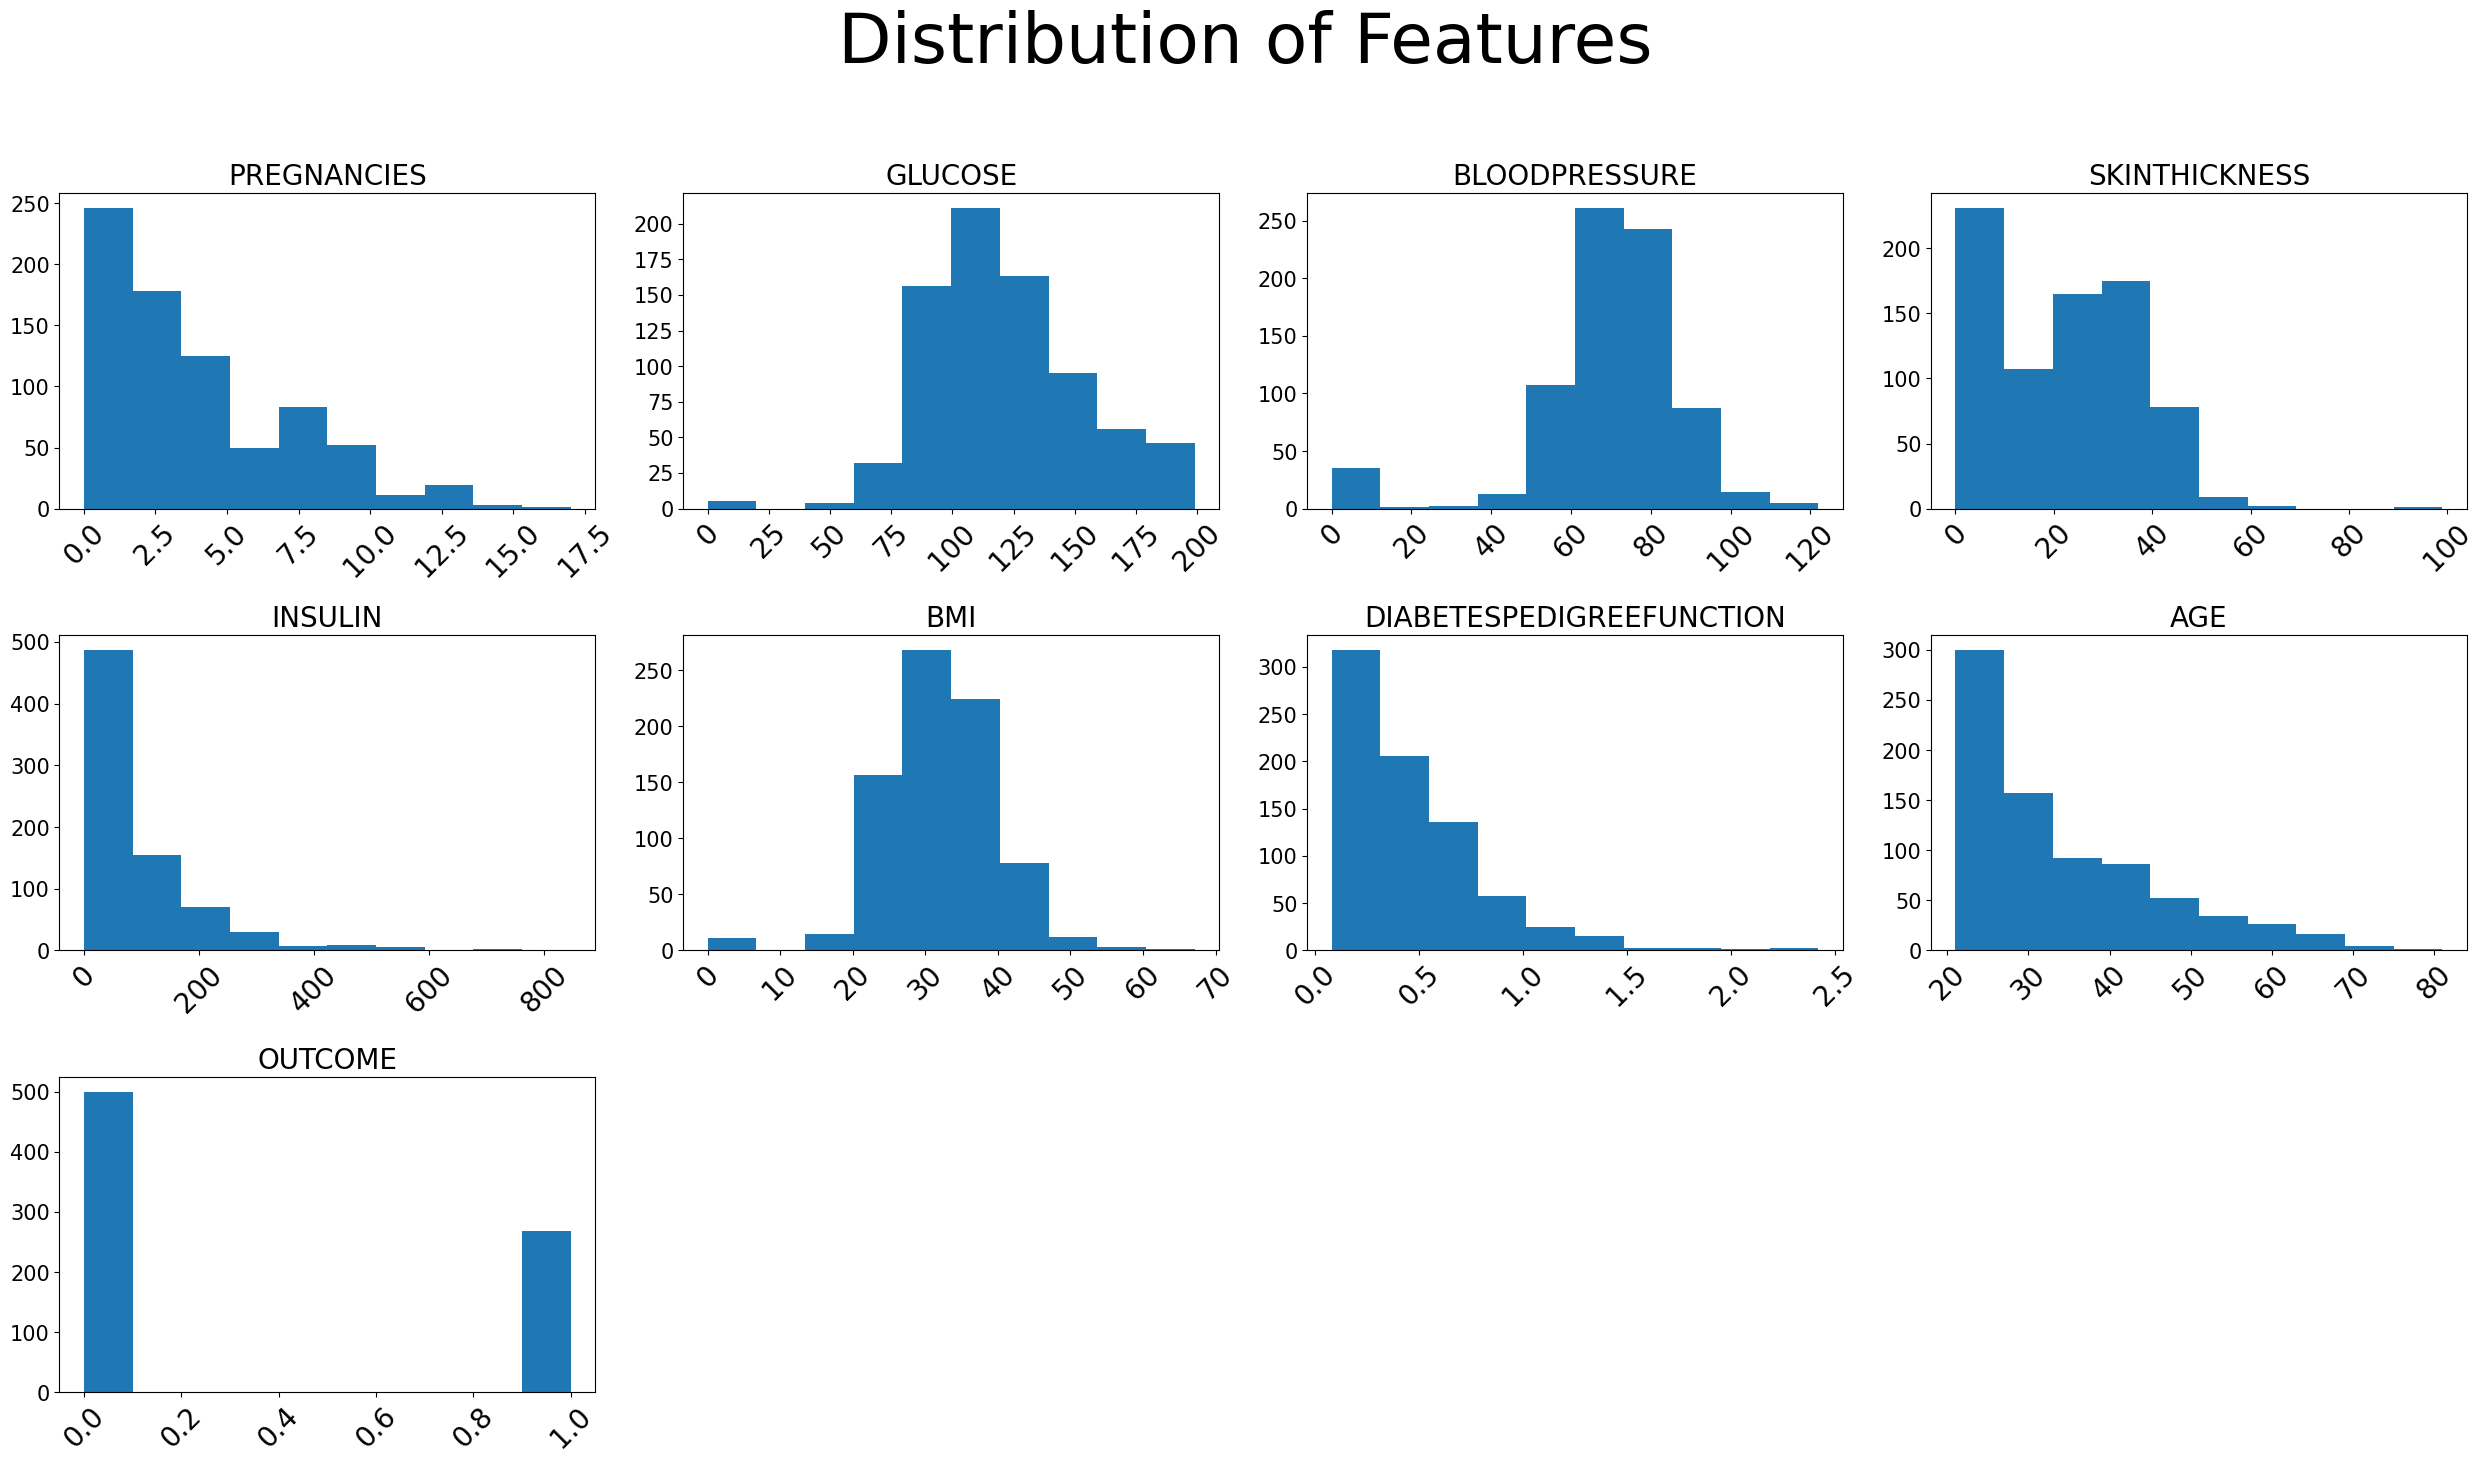

In [18]:
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
  ax = fig.add_subplot(3,4, num)
  ax.hist(df.toPandas()[col])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [21]:
y_udf = udf(lambda y: "no" if y == 0 else "yes", StringType())

In [22]:
df = df.withColumn("HasDiabetes",y_udf('Outcome')).drop("Outcome")
     

In [23]:
df.show(3)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|        yes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
only showing top 3 rows



In [39]:
def udf_multi(age):
  if (age < 25):
    return "Under 25"
  elif (age >=25 and age <= 35):
    return "Between 25 and 35"
  elif (age > 35 and age < 50):
    return "Between 36 and 50"
  elif (age >= 50):
    return "Over 50"
  else: return "NA"

In [40]:
age_udf = udf(udf_multi)
df = df.withColumn('age_udf', age_udf('Age'))

In [41]:
df.show(2)   


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|          age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|Between 25 and 35|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
only showing top 2 rows



In [42]:
from pyspark.sql import functions as F 
from pyspark.sql.functions import rank, sum, desc 
from pyspark.sql import Window

In [43]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [45]:
age_group_tab = df.select(["age_udf","Glucose"]).\
                      groupBy('age_udf').\
                          agg(
                              F.count('Glucose').alias('UserCount'),
                              F.mean('Glucose').alias('Glucose_AVG'),
                              F.min('Glucose').alias('Glucose_MIN'),
                              F.max('Glucose').alias('Glucose_MAX')).\
                          withColumn('total', sum(col('UserCount')).over(window)).\
                          withColumn('Percent', col('UserCount')*100 / col('total')).\
                          drop(col('total')).sort(desc('Percent'))

TypeError: 'str' object is not callable

In [46]:
age_group_tab.toPandas()

NameError: name 'age_group_tab' is not defined

In [47]:
sns.barplot(x="age_udf", y="Percent",data=age_group_tab.toPandas());
     

NameError: name 'age_group_tab' is not defined